[![Map Pipeline](https://github.com/YertleTurtleGit/depth-from-normals/actions/workflows/map_pipeline.yml/badge.svg)](https://github.com/YertleTurtleGit/depth-from-normals/actions/workflows/map_pipeline.yml)
[![Lint](https://github.com/YertleTurtleGit/depth-from-normals/actions/workflows/lint.yml/badge.svg)](https://github.com/YertleTurtleGit/depth-from-normals/actions/workflows/lint.yml)
<a target="_blank" href="https://colab.research.google.com/github/YertleTurtleGit/depth-from-normals">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<!-- START doctoc generated TOC please keep comment here to allow auto update -->
<!-- END doctoc generated TOC please keep comment here to allow auto update -->

# Introduction


This algorithm estimates a 3d integral with the normal mapping with surface integrals of vector fields. First the directional gradients of the normals in x- and y-direction are calculated. They are then used to calculate the integrated values by a cumulative sum (Riemann sum). This process is repeated with differently rotated versions of the gradient mapping to average the values and reduce errors as a cumulative sum alone is very prone for subsequent errors.


# Imports & Inputs

In [1]:
import numpy as np
import cv2 as cv
from scipy.integrate import cumulative_trapezoid, simpson
from skimage import io
from math import sin, cos, radians, degrees, pi, floor
from threading import Thread, Lock
from typing import List, Tuple, Union
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm

In [2]:
NORMAL_MAP_A_PATH: str = "https://raw.githubusercontent.com/YertleTurtleGit/depth-from-normals/main/normal_mapping_a.png"  # @param {type: "string"}
NORMAL_MAP_B_PATH: str = "https://raw.githubusercontent.com/YertleTurtleGit/depth-from-normals/main/normal_mapping_b.png"
NORMAL_MAP_A_IMAGE: np.ndarray = io.imread(NORMAL_MAP_A_PATH)
NORMAL_MAP_B_IMAGE: np.ndarray = io.imread(NORMAL_MAP_B_PATH)

# Explanation


## Gradients

First we calculate the anisotropic (directional) gradients from our normal map.

Given the normal vector $\vec{n} \in \mathbb{R}^{3}$ and a rotation value $r \in \mathbb{R}[0,2\pi]$, the anisotropic gradients are calculated:

$$
a_h = \arccos{\vec{n_x}}, \hspace{5px} g_l = (1 - \sin{a_h}) * sgn(a_h - \frac{\pi}{2})
$$

$$
a_v = \arccos{\vec{n_y}}, \hspace{5px} g_t = (1 - \sin{a_v}) * sgn(a_v - \frac{\pi}{2})
$$

This will be calculated for every pixel and for every rotation value.


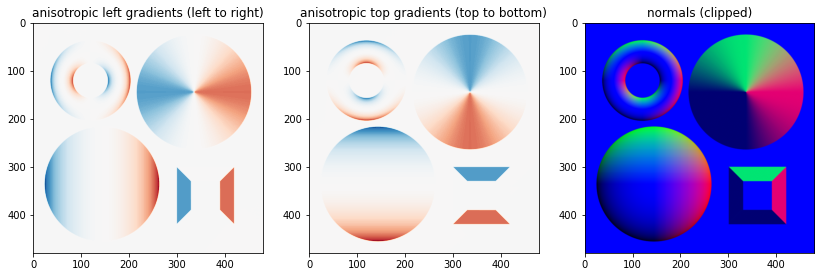

In [3]:
def calculate_gradients(normals):
    horizontal_angle_map = np.arccos(np.clip(normals[:, :, 0], -1, 1))
    left_gradients = (1 - np.sin(horizontal_angle_map)) * np.sign(
        horizontal_angle_map - pi / 2
    )

    vertical_angle_map = np.arccos(np.clip(normals[:, :, 1], -1, 1))
    top_gradients = -(1 - np.sin(vertical_angle_map)) * np.sign(
        vertical_angle_map - pi / 2
    )

    return left_gradients, top_gradients


normals = ((NORMAL_MAP_A_IMAGE[:, :, :3] / 255) - 0.5) * 2
left_gradients, top_gradients = calculate_gradients(normals)


figsize = (14, 14)
figure, axes = plt.subplots(1, 3, figsize=figsize)
axes[0].set_title("anisotropic left gradients (left to right)")
_ = axes[0].imshow(left_gradients, cmap="RdBu", norm=TwoSlopeNorm(0))
axes[1].set_title("anisotropic top gradients (top to bottom)")
_ = axes[1].imshow(top_gradients, cmap="RdBu", norm=TwoSlopeNorm(0))
axes[2].set_title("normals (clipped)")
_ = axes[2].imshow(np.clip(normals, 0, 255))

## Heights

The height values $h(x,y) \in \mathbb{R}^{2}, \ \ x,y \in \mathbb{N}^{0}$ can be calculated by a anisotropic cumulative sum over the gradients which converges to an integral over $g(x,y)$:

$$
h(x_t,y_t) = \iint g(x,y) dydx \ \ (x_t,y_t) \approx \sum_{x_i=0}^{x_t} g(x_i,y_t)
$$

The isotropic (non-directional) heights are determined with a combination of all anisotropic heights.


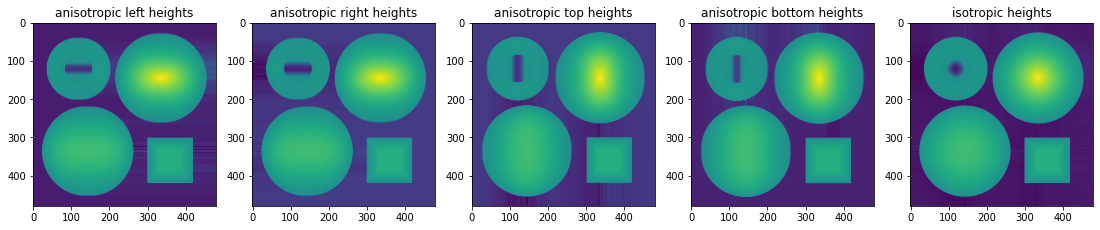

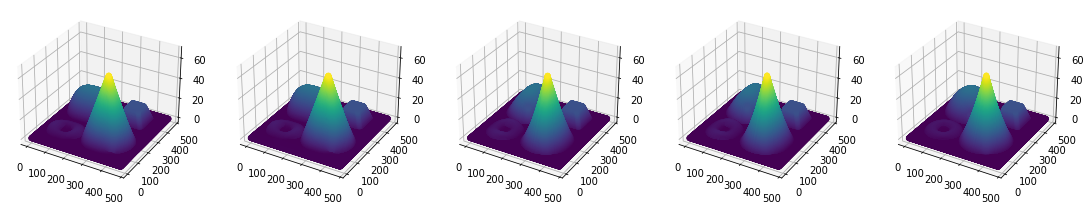

In [4]:
def integrate_gradient_field(gradient_field, axis):
    integral = np.zeros(gradient_field.shape[:2])

    return np.cumsum(gradient_field, axis=axis)
    # return cumulative_trapezoid(gradient_field, axis=axis)
    if axis == 1:
        for y in range(gradient_field.shape[0]):
            for x in range(1, gradient_field.shape[1]):
                integral[y, x] = simpson(gradient_field[y, :x])

    elif axis == 0:
        for y in range(1, gradient_field.shape[0]):
            for x in range(gradient_field.shape[1]):
                integral[y, x] = simpson(gradient_field[y - 1 : y + 1, x])

    return integral


def calculate_heights(left_gradients, top_gradients):
    left_heights = integrate_gradient_field(left_gradients, axis=1)
    right_heights = np.fliplr(
        integrate_gradient_field(np.fliplr(-left_gradients), axis=1)
    )
    top_heights = integrate_gradient_field(top_gradients, axis=0)
    bottom_heights = np.flipud(
        integrate_gradient_field(np.flipud(-top_gradients), axis=0)
    )
    return left_heights, right_heights, top_heights, bottom_heights


left_heights, right_heights, top_heights, bottom_heights = calculate_heights(
    left_gradients, top_gradients
)


def combine_heights(*heights):
    std = np.std(heights, axis=0)
    mean = np.mean(heights, axis=0)
    median = np.median(heights, axis=0)
    return mean

    outlier_mask = None

    for height in heights:
        outlier_mask = np.abs(height - mean) < std * 1.1
        height[outlier_mask] = mean[outlier_mask] - height[outlier_mask] * (
            len(heights) / len(heights) - 1
        )

    return np.mean(heights, axis=0)


isotropic_heights = combine_heights(
    left_heights, right_heights, top_heights, bottom_heights
)


def visualize_heights(left_heights, top_heights, isotropic_heights):
    figure, axes = plt.subplots(1, 5, figsize=(19, 5))
    axes[0].set_title("anisotropic left heights")
    _ = axes[0].imshow(left_heights, norm=TwoSlopeNorm(0.5))
    axes[1].set_title("anisotropic right heights")
    _ = axes[1].imshow(right_heights, norm=TwoSlopeNorm(0.5))
    axes[2].set_title("anisotropic top heights")
    _ = axes[2].imshow(top_heights, norm=TwoSlopeNorm(0.5))
    axes[3].set_title("anisotropic bottom heights")
    _ = axes[3].imshow(bottom_heights, norm=TwoSlopeNorm(0.5))
    axes[4].set_title("isotropic heights")
    _ = axes[4].imshow(isotropic_heights, norm=TwoSlopeNorm(0.5))

    x, y = np.meshgrid(range(left_heights.shape[0]), range(left_heights.shape[1]))
    figure, axes = plt.subplots(1, 5, subplot_kw={"projection": "3d"}, figsize=(19, 5))
    _ = axes[0].scatter(x, y, left_heights, c=left_heights)
    _ = axes[1].scatter(x, y, right_heights, c=right_heights)
    _ = axes[2].scatter(x, y, top_heights, c=top_heights)
    _ = axes[3].scatter(x, y, bottom_heights, c=bottom_heights)
    _ = axes[4].scatter(x, y, isotropic_heights, c=isotropic_heights)


visualize_heights(left_heights, top_heights, isotropic_heights)

## Rotation

This alone is very prone for errors. That’s why rotation is introduced. When re-calculating the gradient map multiple times with a rotation factor and using that to calculate the height values for every re-calculated gradient map, adding this values together drastically improves the resulting height values:

$$
h(x_t,y_t) = \sum_{r=0}^{2\pi} \sum_{x_i=0}^{x_t} g R_\theta (x_i,y_t)
$$

If we think of the left, right, top and bottom height maps in polar coordinates, we better call them 180°, 0°, 90° and 270° height maps.


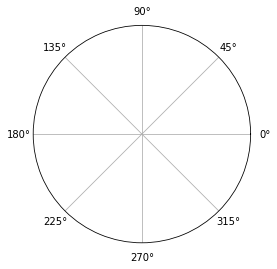

In [5]:
plt.polar()
_ = plt.yticks([1])

If we want to for example calculate a 225° anisotropic height map, we need to rotate the normal map first, but a simple image-rotation will result in wrong normals. Thus, we also need to rotate the normals accordingly.


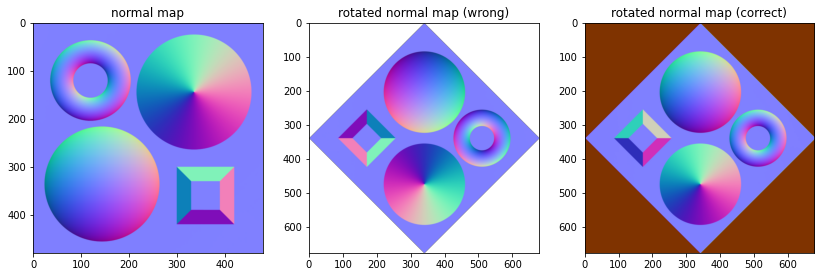

In [6]:
ANGLE = 225


def rotate(matrix, angle):
    image_size = (matrix.shape[1], matrix.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    rotation_matrix = np.matrix(
        np.vstack([cv.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]])
    )
    translation_matrix = np.matrix(np.identity(3))

    w2 = image_size[0] * 0.5
    h2 = image_size[1] * 0.5

    rot_mat_notranslate = np.matrix(rotation_matrix[0:2, 0:2])

    tl = (np.array([-w2, h2]) * rot_mat_notranslate).A[0]
    tr = (np.array([w2, h2]) * rot_mat_notranslate).A[0]
    bl = (np.array([-w2, -h2]) * rot_mat_notranslate).A[0]
    br = (np.array([w2, -h2]) * rot_mat_notranslate).A[0]

    x_coords = [pt[0] for pt in [tl, tr, bl, br]]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in [tl, tr, bl, br]]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))
    new_image_size = (new_w, new_h)

    new_midx = new_w * 0.5
    new_midy = new_h * 0.5

    dx = int(new_midx - w2)
    dy = int(new_midy - h2)

    translation_matrix = np.matrix(np.array([[1, 0, dx], [0, 1, dy], [0, 0, 1]]))
    affine_mat = (np.matrix(translation_matrix) * rotation_matrix)[0:2, :]
    result = cv.warpAffine(matrix, affine_mat, new_image_size, flags=cv.INTER_LINEAR)

    return result


rotated_normal_map_wrong = rotate(NORMAL_MAP_A_IMAGE, ANGLE)

wrong_normals = (
    (rotated_normal_map_wrong[:, :, :3].astype(np.float64) / 255) - 0.5
) * 2


def rotate_vector_field_normals(normals, angle):
    rotated_normals = normals.copy()
    rotated_normals[:, :, 0] = normals[:, :, 0] * cos(radians(angle))
    rotated_normals[:, :, 0] -= normals[:, :, 1] * sin(radians(angle))
    rotated_normals[:, :, 1] = normals[:, :, 0] * sin(radians(angle))
    rotated_normals[:, :, 1] += normals[:, :, 1] * cos(radians(angle))
    return rotated_normals


rotated_normals = rotate_vector_field_normals(wrong_normals, ANGLE)
rotated_normal_map = (((rotated_normals + 1) / 2) * 255).astype(np.uint8)

figure, axes = plt.subplots(1, 3, figsize=figsize)
axes[0].set_title("normal map")
_ = axes[0].imshow(NORMAL_MAP_A_IMAGE)
axes[1].set_title("rotated normal map (wrong)")
_ = axes[1].imshow(rotated_normal_map_wrong)
axes[2].set_title("rotated normal map (correct)")
_ = axes[2].imshow(rotated_normal_map)

In [7]:
def centered_crop(image: np.ndarray, target_resolution: Tuple[int, int]) -> np.ndarray:
    return image[
        (image.shape[0] - target_resolution[0])
        // 2 : (image.shape[0] - target_resolution[0])
        // 2
        + target_resolution[0],
        (image.shape[1] - target_resolution[1])
        // 2 : (image.shape[1] - target_resolution[1])
        // 2
        + target_resolution[1],
    ]

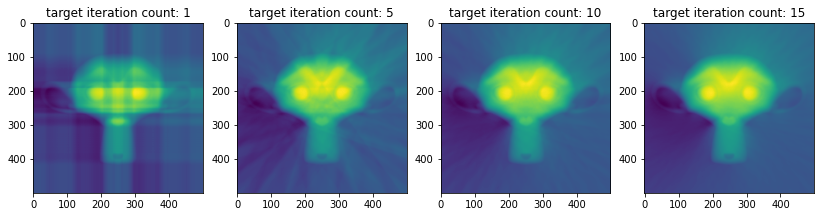

In [8]:
def integrate_vector_field(vector_field, target_iteration_count):
    isotropic_height = np.zeros(vector_field.shape[:2])
    angles = np.linspace(0, 90, target_iteration_count, endpoint=False)
    iterations = len(angles)

    for index, angle in enumerate(angles):
        rotated_vector_field = rotate_vector_field_normals(
            rotate(vector_field, angle), angle
        )
        left_gradients, top_gradients = calculate_gradients(rotated_vector_field)

        left_heights, right_heights, top_heights, bottom_heights = calculate_heights(
            left_gradients, top_gradients
        )
        combined_heights = combine_heights(
            left_heights, right_heights, top_heights, bottom_heights
        )
        combined_heights = centered_crop(
            rotate(combined_heights, -angle), isotropic_height.shape
        )

        isotropic_height += combined_heights / iterations

    return isotropic_height


def estimate_height_map(
    normal_map: np.ndarray, target_iteration_count: int = 250
) -> np.ndarray:
    normals = ((normal_map[:, :, :3] / 255) - 0.5) * 2
    heights = integrate_vector_field(normals, target_iteration_count)
    return heights


figure, axes = plt.subplots(1, 4, figsize=(14, 6))

for index in range(4):
    target_iteration_count = max(1, index * 5)
    heights = estimate_height_map(NORMAL_MAP_B_IMAGE, target_iteration_count)
    x, y = np.meshgrid(range(heights.shape[0]), range(heights.shape[1]))

    axes[index].set_title(f"target iteration count: {target_iteration_count}")
    _ = axes[index].imshow(heights)


# Example Usage

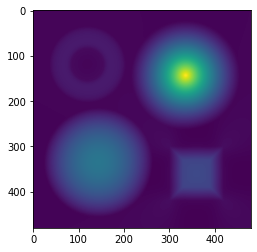

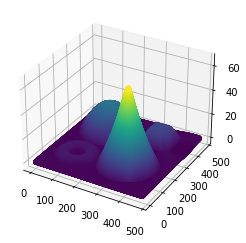

In [9]:
heights = estimate_height_map(NORMAL_MAP_A_IMAGE)

_ = plt.imshow(heights)
x, y = np.meshgrid(range(heights.shape[1]), range(heights.shape[0]))
_, axes = plt.subplots(1, 1, subplot_kw={"projection": "3d"})
_ = axes.scatter(x, y, heights, c=heights)